In [2]:

import os
import re
import json
import time
import sqlite3
from typing import List, Dict, Any, Optional

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import re

from dotenv import load_dotenv
load_dotenv()

# LangChain / LangGraph imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langchain_groq import ChatGroq

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


c:\Users\kashi\miniconda3\envs\myenv\lib\site-packages\google\api_core\_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.25) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
c:\Users\kashi\miniconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SERPAPI_KEY = os.getenv("SERPAPI_KEY", "")
if not SERPAPI_KEY:
    raise RuntimeError("Set SERPAPI_KEY env var before running")

CHECKPOINT_DB = os.getenv("CHECKPOINT_DB", "./langgraph_checkpoints.db")
ALPHAVANTAGE_KEY = os.getenv("ALPHAVANTAGE_KEY", "BR1UI7DQQ6WKTV5N")  # keep original if present


In [4]:
def serp_search_news(query: str, num_results: int = 5) -> List[Dict[str, Any]]:
    
    
    url = "https://google.serper.dev/search"

    payload = {
        "q": query ,
        "tbs": "qdr:m"
    }
    headers = {
        'X-API-KEY': SERPAPI_KEY,
        'Content-Type': 'application/json'
    }

    response = requests.post(url, headers=headers, json=payload)

    # Parse and pretty print JSON
    data = response.json()
    res = []
    for i in data['organic']:
        res.append(i['link'])
    return res[0]

In [5]:
ssr= serp_search_news("Tata Steel latest news") 
    
    

In [6]:
ssr

'https://www.goodreturns.in/news/1-2-bonus-1-10-split-dividends-tatas-steel-stock-tata-steel-recommended-to-buy-highest-target-rs-210-1474999.html'

In [7]:
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (compatible; RiskAgent/1.0; +https://example.com/bot)'
}

def scrape_article_content(url: str, timeout: int = 10) -> Dict[str, Any]:
    try:
        domain = urlparse(url).netloc.lower()
        skip_domains = ['youtube.com', 'facebook.com', 'twitter.com', 'instagram.com', 'linkedin.com', 'reddit.com']
        if any(skip in domain for skip in skip_domains) or url.lower().endswith(".pdf"):
            return {"success": False, "reason": "Non-article domain"}

        resp = requests.get(url, headers=HEADERS, timeout=timeout)
        if resp.status_code != 200:
            return {"success": False, "reason": f"HTTP {resp.status_code}"}

        soup = BeautifulSoup(resp.content, "html.parser")
        for s in soup(["script", "style", "nav", "footer", "header"]):
            s.decompose()

        title = ""
        if soup.title:
            title = soup.title.get_text().strip()
        h1 = soup.find("h1")
        if h1 and len(h1.get_text().strip()) > len(title):
            title = h1.get_text().strip()

        article_selectors = [
            'article', '.article-content', '.post-content', '.entry-content',
            '.story-body', '.article-body', 'main'
        ]
        content = ""
        for sel in article_selectors:
            node = soup.select_one(sel)
            if node:
                ps = node.find_all("p")
                content = " ".join([p.get_text().strip() for p in ps if len(p.get_text().strip()) > 40])
                if len(content) > 200:
                    break

        if not content or len(content) < 200:
            ps = soup.find_all("p")
            content = " ".join([p.get_text().strip() for p in ps if len(p.get_text().strip()) > 40])

        content = re.sub(r'\s+', ' ', content).strip()
        if len(content) < 100:
            return {"success": False, "reason": "Content too short"}

        return {"content": content[:5000]}

    except Exception as e:
        return {"success": False, "reason": str(e)[:200]}


In [8]:
scrp = scrape_article_content('https://www.goodreturns.in/news/1-2-bonus-1-10-split-dividends-tatas-steel-stock-tata-steel-recommended-to-buy-highest-target-rs-210-1474999.html')

In [9]:
scrp['content']

'Tata Steel, the metals and mining flagship of Tata Group, has recorded more than 3.5% growth on BSE and NSE year-to-date. Metal stocks are in focus as COMEX copper rose nearly 3%, reaching a multi-month high. Amidst expectations of easing in bolstered sentiment across the industrial metals space, Tata Steel is among the top picks in the sector. The majority of analysts have recommended BUY with target prices ranging from Rs 200 to Rs 210. After market hours on December 5th, Tata Steel stood at Rs 167.10 apiece on BSE, with a market cap of Rs 2,08,723.16 crore. The stock is less than Rs 20 away from hitting its 52-week high of Rs 187. YTD, the stock is up by 3.53% on BSE. From its 52-week low of Rs 122.60 apiece, Tata Steel gained by more than 36% as of now. Tata Steel has rewarded investors with a hefty dividend and is among top dividend yield stock in the sector. It has also carried one stock split and bonus issue in its history so far. The first time Tata Steel rewarded investors wi

In [10]:
@tool
def serp_tool(query: str, num_results: int = 5) -> Dict[str, Any]:
    """Tool does google search and shows the single most relevant search for the query."""
    try:
        results = serp_search_news(query, num_results=num_results)
        return {"success": True, "results": results}
    except Exception as e:
        return {"success": False, "error": str(e)}

@tool
def scrape_tool(url: str) -> Dict[str, Any]:
    """Tool scrapes the content accurately of the provided link and this data can be used by the LLM for risk scoring the company."""
    try:
        res = scrape_article_content(url)
        return res
    except Exception as e:
        return {"success": False, "error": str(e)}
    
    


In [11]:
  


# Tools list that LLM can choose from
TOOLS = [serp_tool, scrape_tool]

In [12]:
# LLM instance (Gemini)
#llm = ChatGroq(temperature=0.4, model="qwen/qwen3-32b")
llm = ChatGroq(temperature=0.4, model="moonshotai/kimi-k2-instruct-0905")
llm_bound = llm.bind_tools(TOOLS) 

In [13]:
llm_bound.invoke('{"message": "you are a helpful assitant, your task is to find the latest information about tatasteel and give them a risk score so that i can decide whether to buy from them or not and the risk score will be given on the basis of whether the news is good or not. you are also provided with tools that you can use to find the link and then scrape the info , which you can use to give a risk_score to the company , if bad_news = high score else low score "}' )

AIMessage(content="I'll help you analyze Tata Steel's latest information and provide a risk score for your purchasing decision. Let me search for the most recent news about Tata Steel.", additional_kwargs={'tool_calls': [{'id': 'functions.serp_tool:0', 'function': {'arguments': '{"query":"Tata Steel latest news 2024 financial performance"}', 'name': 'serp_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 295, 'total_tokens': 353, 'completion_time': 0.204372778, 'completion_tokens_details': None, 'prompt_time': 0.033874423, 'prompt_tokens_details': None, 'queue_time': 0.311390446, 'total_time': 0.238247201}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_241bc7119c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9d92a73d-97ad-4507-a20b-17b1d7730813-0', tool_calls=[{'name': 'serp_tool', 'args': {'query': 'Tata Steel latest news 2024 financial performance'}, 'id

In [14]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage] ,  add_messages]


In [15]:
def chat_node(state:ChatState):
    """
    LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_bound.invoke(messages)
    return {'messages':[response]}

tool_node = ToolNode(TOOLS)
  

In [16]:
  
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)


In [17]:
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge('tools', 'chat_node')  



In [18]:
chatbot = graph.compile()

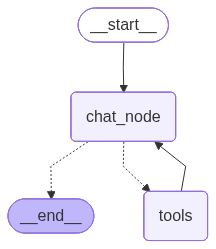

In [19]:
chatbot

In [22]:
out = chatbot.invoke({'messages':[HumanMessage(content="""You are a Risk Scoring Agent.

Your ONLY job:
Given one or more company names, for each company:
1. Use "serp_tool" to fetch one news article URL about the company (latest or most relevant).
2. Then use "scrape_tool" on that URL to get the article content.
3. Read the scraped content and classify the sentiment as Good / Neutral / Bad.
4. Assign a Risk Score:
      Bad news   → High Risk (8–10)
      Neutral    → Medium Risk (4–7)
      Positive   → Low Risk (1–3)
5. Output results in this JSON format:



### VERY IMPORTANT RULES
- You MUST NOT use browser.search or browser.open.
- You must ONLY use:
     • serp_tool → to get URL
     • scrape_tool → to extract content from URL
- One URL per company only.
- No loops, no recursion, no re-thinking steps.
- Process companies sequentially. Finish one → move to next.
- If any tool fails, return "Unable to fetch" for that company instead of looping.
- In the serp_tool try to put relevent search query
- I want the the article or url should be related to company , as supplier how good that company is in that part (supplying and then overall too.)

After processing all companies, return the final JSON list like this,make sure it is json or dictionary:

[
  {company1 , risk score/10},
  {company2 , risk score/10},
  {company3 , risk_score/10}
]

Input:
COMPANIES:   Tata steel 
""") ]})


In [23]:
out['messages'][-1].content

'Based on the article content, I can analyze Tata Steel\'s supply chain position and overall performance. The article discusses Tata Steel UK\'s involvement in strengthening the UK\'s industrial supply chain through circular steel initiatives and EAF (Electric Arc Furnace) technology transition.\n\n**Sentiment Analysis**: The sentiment is **Good/Positive**. The article highlights Tata Steel UK\'s leadership role (CEO Rajesh Nair is Chair of UK Steel) in driving sustainable steel production, circular economy initiatives, and positioning the UK as a leader in circular steel economy. The company is actively participating in policy development and industry transformation.\n\n**Risk Assessment**: This represents **Low Risk** as Tata Steel is:\n- Taking a leadership position in industry transformation\n- Actively working to strengthen supply chains\n- Positioned well for the transition to low-carbon steel production\n- Involved in strategic policy development\n\n```json\n[\n  {"Tata Steel": 

In [154]:
{
  "company": "<company_name>",
  "status": "good / neutral / bad",
  "risk_score": <number>,
  "reason": "<one short sentence based on scraped news>"
}

, National steel Co

SyntaxError: invalid syntax (189357913.py, line 4)

In [ ]:
BadRequestError: 